<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Class                     768 non-null    object 
dtypes: float64(2), int64(6), object(1)
memory usage: 51.1+ KB
The skewness of Pregnancies is 0.9016739791518588
The skewness of Glucose is 0.5327186599872982
The skewness of BloodPressure is 0.13730536744146796
The skewness of SkinThickness is 0.8376083316006523
The skewness of Insulin is 

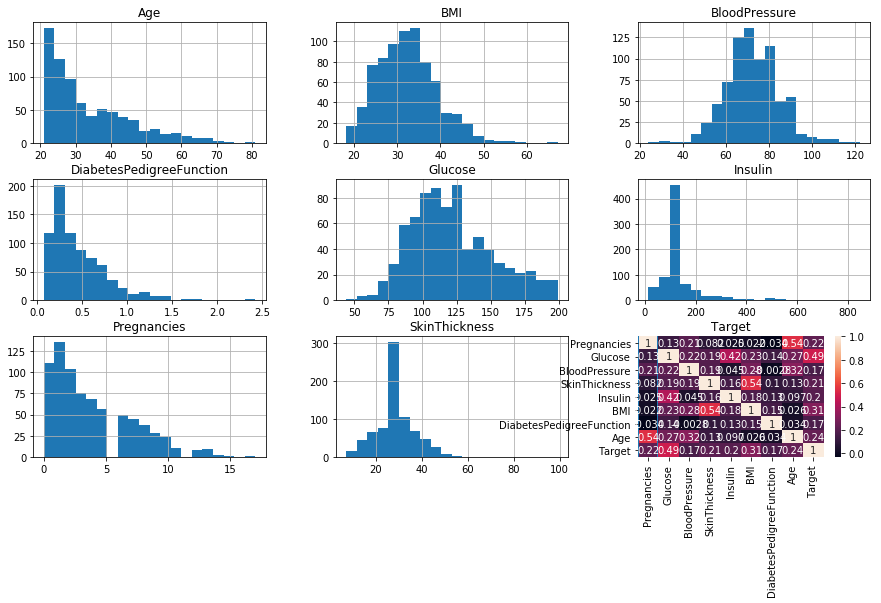

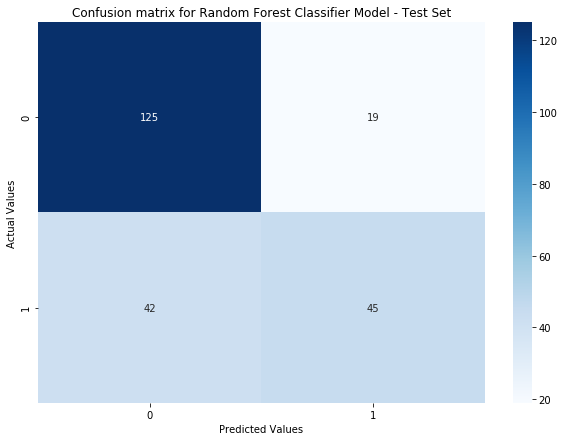

Accuracy on test set: 73.59%
              precision    recall  f1-score   support

           0       0.75      0.87      0.80       144
           1       0.70      0.52      0.60        87

    accuracy                           0.74       231
   macro avg       0.73      0.69      0.70       231
weighted avg       0.73      0.74      0.73       231



In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

data = pd.read_csv(r'C:\Users\lenovo\Downloads\DS_Practice\Diabetes_Detection\diabetes_data.csv')
data.head(3)

## Rename column names 
data.columns =['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI', 'DiabetesPedigreeFunction','Age','Class']

data.info()
data.describe()

data.Class.value_counts(normalize=True)*100

# Replacing the 0 values from ['Glucose','BloodPressure','SkinThickness','Insulin','BMI'] by NaN baacuse it cannot be 0.
df_model = data.copy(deep=True)
df_model[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df_model[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

## Total null values in each column of dataframe
df_model.isnull().sum()

# Replacing NaN value by mean, median depending upon distribution
df_model['Glucose'].fillna(df_model['Glucose'].mean(), inplace=True)
df_model['BloodPressure'].fillna(df_model['BloodPressure'].mean(), inplace=True)
df_model['SkinThickness'].fillna(df_model['SkinThickness'].median(), inplace=True)
df_model['Insulin'].fillna(df_model['Insulin'].median(), inplace=True)
df_model['BMI'].fillna(df_model['BMI'].median(), inplace=True)

# Import label encoder 
from sklearn import preprocessing 

# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
df_model['Target']= label_encoder.fit_transform(df_model['Class']) 

## Drop class column 
df_model.drop('Class', inplace=True, axis=1)

#skewness of columns
for i in df_model.columns:
    print("The skewness of "+ i +" is {}".format(df_model[i].skew()))

## Plot histogram of numeric features  
df_model.hist(bins=20, figsize=(15,8))

## Create a heatmap of correlation matrix between features.
df_model.corr()
sns.heatmap(df_model.corr(), annot=True)

## Model Development
# Using GridSearchCV to find the best algorithm for this problem
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split

X = df_model.drop(columns=['Target'], axis=1)
y = df_model['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=10)

print('X_train size: {}, X_test size: {}'.format(X_train.shape, X_test.shape))

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Creating a function to calculate best model for this problem
def find_best_model(X, y):
    models = {
        'logistic_regression': {
            'model': LogisticRegression(solver='lbfgs', multi_class='auto'),
            'parameters': {
                'C': [1,5,10]
               }
        },
        
        'decision_tree': {
            'model': DecisionTreeClassifier(splitter='best'),
            'parameters': {
                'criterion': ['gini', 'entropy'],
                'max_depth': [5,10]
            }
        },
        
        'random_forest': {
            'model': RandomForestClassifier(criterion='gini'),
            'parameters': {
                'n_estimators': [10,15,20,50,100,200]
            }
        },
        
        'svm': {
            'model': SVC(gamma='auto'),
            'parameters': {
                'C': [1,10,20],
                'kernel': ['rbf','linear']
            }
        }

    }
    
    scores = [] 
    cv_shuffle = ShuffleSplit(n_splits=5, test_size=0.30, random_state=0)
        
    for model_name, model_params in models.items():
        gs = GridSearchCV(model_params['model'], model_params['parameters'], cv = cv_shuffle, return_train_score=False)
        gs.fit(X, y)
        scores.append({
            'model': model_name,
            'best_parameters': gs.best_params_,
            'score': gs.best_score_
        })
        
    return pd.DataFrame(scores, columns=['model','best_parameters','score'])

## Check score of each model for evaluation
find_best_model(X_train, y_train)

## According to above score table random forest regressor is best model.

# Using cross_val_score for gaining average accuracy
from sklearn.model_selection import cross_val_score
scores = cross_val_score(RandomForestClassifier(n_estimators=20, random_state=0), X_train, y_train, cv=5)
print('Average Accuracy : {}%'.format(round(sum(scores)*100/len(scores)), 3))

# Creating Random Forest Model
classifier = RandomForestClassifier(n_estimators=20, random_state=0)
classifier.fit(X_train, y_train)

# Creating a confusion matrix for test set
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
y_pred = classifier.predict(X_test)
con_mat = confusion_matrix(y_test, y_pred)
con_mat

# Plotting the confusion matrix
plt.figure(figsize=(10,7))
p = sns.heatmap(con_mat, annot=True, cmap="Blues", fmt='g')
plt.title('Confusion matrix for Random Forest Classifier Model - Test Set')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

# Accuracy Score
score = round(accuracy_score(y_test, y_pred),4)*100
print("Accuracy on test set: {}%".format(score))

# Classification Report
print(classification_report(y_test, y_pred))

# Creating a pickle file for the classifier
filename = 'diabetes-prediction-model.pkl'
pickle.dump(classifier, open(filename, 'wb'))